### Title: RNA Seq analysis of SN6552 and SN6553 (AITL) samples <BR>
Date: 8/13/19 <br>
Author: Ajit Johnson Nirmal<br>

In [1]:
# Set Working Directory
# Lab
#setwd("C:/Users/ajn16/Dropbox (Partners HealthCare)/Data/aitl_sam")
# Laptop
setwd("/Users/aj/Dropbox (Partners HealthCare)/Data/aitl_sam")

In [2]:
# Save or load Object
#save.image(file='aitl_analysis.RData')
load('aitl_analysis.RData')

In [2]:
# Load data
# Lab
exp <- read.csv("C:/Users/ajn16/Dropbox (Partners HealthCare)/Data/aitl_sam/raw_counts/STAR_Gene_Counts.csv", header = T, row.names = 1)
meta <- read.csv("C:/Users/ajn16/Dropbox (Partners HealthCare)/Data/aitl_sam/raw_counts/meta.csv", header = T, row.names = 1)
# mac
#exp <- read.csv("/Users/aj/Dropbox (Partners HealthCare)/Data/aitl_sam/raw_counts/STAR_Gene_Counts.csv", header = T, row.names = 1)
#meta <- read.csv("/Users/aj/Dropbox (Partners HealthCare)/Data/aitl_sam/raw_counts/meta.csv", header = T, row.names = 1)

In [4]:
# Create the dds object to get the normalized data
library("DESeq2")
dds <- DESeqDataSetFromMatrix(countData = exp, colData = meta, design = ~ group)
dds <- DESeq(dds)
# Extract the normalised data from the deseq file
n_data <- log2(counts(dds, normalized=TRUE)+1)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


### Calculating and plotting the most variable genes

In [7]:
# Custom Function
mostVar <- function(data, n, i_want_most_var = TRUE, meta) {
    require("RColorBrewer")
    require("DESeq2")
    # Function to ge the Most variable genes
    data.var <- apply(data, 1, stats::var)
    data[order(data.var, decreasing = i_want_most_var)[1:n],]
    variable_genes <- data
    # Heatmap of the most variable genes
    # Create the grouping for coloring by disease
    my_group = factor(meta$group)
    my_col = brewer.pal(length(levels(factor(meta$group))), "Set1")[my_group]
    # Color pallet for heatmap
    coul = colorRampPalette(brewer.pal(9,"OrRd"))(10)
    # Export most variable genes and corresponding figure
    dir.create("most variable genes")
    write.csv(variable_genes, file = "most variable genes/3000_mvg.csv")
    pdf("most variable genes/3000_mvg.pdf",width=6,height=6,paper='special')
    heatmap(as.matrix(variable_genes), Colv = NA, scale="row", ColSideColors=my_col, col =coul, hclustfun = hclust)
    dev.off()
}

In [8]:
# Run the function
mostVar(data=n_data, n=3000, i_want_most_var = TRUE, meta = meta)

Loading required package: RColorBrewer
Warning message in dir.create("most variable genes"):
"'most variable genes' already exists"

png 
  2

## Master function to calculate Differentially expressed genes, Plot heatmap of the DEG's, Plot PCA, KEGG pathway enrichment analysis, GSEA enrichment analysis, GO enrichment analysis and Plot top outputs of GO, KEGG and GSEA enrichment tests

I've written the function such that any combinations of groups can be given to the function using the following format and the function will perform all the above defined analysis automatically. All the results will be saved in a folder in the working directory. <br>
Format for giving in the comparitive groups: <br>
contrast <- list(A = c(""), B= c(""))

In [8]:
goi_deg_pca_gsea_go <- function(exp,meta,contrast){
  require(goseq)
  require(plyr)
  require(ggplot2)
  require(gridExtra)
  require(stringr)
  require(org.Hs.eg.db)
  require(KEGGREST)
  require(fgsea)
  require(msigdbr)
  require(xlsx)
  require("DESeq2")
  require("RColorBrewer")
  # Generate the DESEq2 data object
  dds <- DESeqDataSetFromMatrix(countData = exp, colData = meta, design = ~ group)
  # Resolve the contrasts
  goi <-  c(paste(unlist(contrast[[1]]), collapse="_"),paste(unlist(contrast[[2]]), collapse="_"))
  groups <- c(unlist(contrast[[1]]),contrast[[2]])
  # Manipulate the dds groups
  dds$group <- mapvalues(dds$group, from=contrast[[1]], to=rep(paste(unlist(contrast[[1]]), collapse="_"),length(contrast[[1]])))
  dds$group <- mapvalues(dds$group, from=contrast[[2]], to=rep(paste(unlist(contrast[[2]]), collapse="_"),length(contrast[[2]])))
  # Run the DeSeq analysis
  dds <- DESeq(dds)
  # Get the normalized matrix for heatmaps
  n_data <- log2(counts(dds, normalized=TRUE)+1)
  # Subset the normalized matrix and dds based on the groups of interest
  n_data_goi <- data.frame(n_data[,unique(grep(paste(groups,collapse="|"), colnames(n_data), value=TRUE))])
  dds_subset <- dds[ , dds$group %in% goi ]
  dds_subset$group <- factor(dds_subset$group)
  # Creating a folder to save results
  print("Creating a folder to store your results")
  dir.create("DGE+PCA+G0+KEGG+GSEA")
  dir.create(paste("DGE+PCA+G0+KEGG+GSEA/",goi[1], " vs ", goi[2],sep = ""))
  location <- paste("DGE+PCA+G0+KEGG+GSEA/",goi[1], " vs ", goi[2],"/",sep = "")

  # DEG
  print("Calculating the differentially expressed genes")
  deg <- results(dds, contrast=c("group",goi[1],goi[2]))
  deg <- deg[order(deg$padj),]
  # Save the DEG matrix
  write.csv(deg, file = paste(location,goi[1], " vs ", goi[2],".csv",sep = ""))

  # HEATMAP for the DEG's
  # Subset the significant genes from deg and subset the rows of n_data based on those genes and columns based on goi
  deg_heatmap <- data.frame(deg[order(deg$log2FoldChange),])
  deg_heatmap <- n_data_goi[row.names(deg_heatmap[which(deg_heatmap$padj <= 0.05), ]), ]
  # Create the grouping for coloring
  my_group = factor(dds_subset$group)
  my_col = brewer.pal(length(levels(factor(dds_subset$group))), "Set1")[my_group]
  coul = colorRampPalette(brewer.pal(9,"OrRd"))(10)
  # Save the heatmap
  print("Generating a heatmap of the diferentially expressed genes")
  pdf(paste(location,"Heatmap- ",goi[1], " vs ", goi[2],".pdf",sep = ""),width=6,height=6,paper='special')
  heatmap(as.matrix(deg_heatmap), Rowv = NA, scale="row", ColSideColors=my_col, col =coul, hclustfun = hclust,margins = c(10, 4))
  dev.off()

  # PCA
  print("Performing Principal Component Analysis")
  rld_dds_subset<- rlog(dds_subset, blind=FALSE)
  pcaData <- plotPCA(rld_dds_subset, intgroup= "group", returnData=TRUE)
  percentVar <- round(100 * attr(pcaData, "percentVar"))
  pca.plot <-   ggplot(pcaData, aes(PC1, PC2, color=group)) + geom_label(aes(label = name)) +
    theme_bw()+ theme(legend.position = "none")
  pdf(paste(location,"PCA- ",goi[1], " vs ", goi[2],".pdf",sep = ""),width=6,height=6,paper='special')
  plot(pca.plot)
  dev.off()

  # GO enrichment analysis for the DEG's
  print("Performing GO enrichment analysis")
  gene.vector=as.integer(row.names(data.frame(deg))%in%row.names(deg_heatmap))
  names(gene.vector)=row.names(data.frame(deg))
  # Prepare for goseq (gene length data for the DEG's)
  pwf=nullp(gene.vector,"hg19","geneSymbol")
  # Using the Wallenius approximation
  GO.wall=goseq(pwf,"hg19","geneSymbol")
  # save the goterms
  write.csv(GO.wall, file = paste(location,"GO Enrichment- ",goi[1], " vs ", goi[2],".csv", sep = ""))

  # Prepare the GO dataframe for generating a figure
  GO.plot <- data.frame()
  for (i in levels(as.factor(GO.wall$ontology))){
    GO.wall_subset <- GO.wall[GO.wall$ontology %in% i,]
    GO.wall_top <- GO.wall_subset[rownames(GO.wall_subset)[order(GO.wall_subset$over_represented_pvalue, decreasing=FALSE)][1:5],]
    GO.wall_top$direction <- "over represented"
    GO.wall_top$p.val <- -log(GO.wall_top$over_represented_pvalue)
    GO.wall_bottom <- GO.wall_subset[rownames(GO.wall_subset)[order(GO.wall_subset$under_represented_pvalue, decreasing=FALSE)][1:5],]
    GO.wall_bottom$direction <- "under represented"
    GO.wall_bottom$p.val <- -log(GO.wall_bottom$under_represented_pvalue)
    GO_subset <- rbind(GO.wall_top,GO.wall_bottom)
    GO.plot <- rbind(GO.plot,GO_subset)
  }

  # Plot the GO.plot data
  GO.plot$term <- factor(GO.plot$term, levels = GO.plot$term) # to avoid re-ordering
  for (i in levels(as.factor(GO.plot$ontology))){
    GO.plot_subset <- GO.plot[GO.plot$ontology %in% i,]
    p<-ggplot(data=GO.plot_subset, aes(x=term, y=p.val,fill=direction)) +
      geom_bar(stat="identity")+ geom_hline(yintercept = 3)+
      coord_flip()+ theme_bw()+ theme(legend.position="bottom",legend.title = element_blank(), axis.text=element_text(size=12)) +
      ggtitle(paste(i, "- Top 5"))+
      scale_x_discrete(labels = function(x) str_wrap(x, width = 25))+
      labs(y = "-log(P value)")
    my_plots[[i]] <- p
  }
  pdf(paste(location,"GO Enrichment- ",goi[1], " vs ", goi[2],".pdf",sep = ""),width=6,height=20,paper='special')
  grid.arrange(grobs = my_plots, ncol = 1)
  dev.off()

  # Kegg Pathway Analysis for the DEG's
  print("Performing KEGG pathway analysis")
  # Get the mapping from GeneName to KEGG
  entrez_symbol <- toTable(org.Hs.egSYMBOL)
  entrez_df <- merge(entrez_symbol,data.frame(deg), by.x="symbol", by.y= "row.names")
  entrez_deg <- entrez_df[which(entrez_df$padj <= 0.05), ]
  # Prepare for GOSeq analysis
  gene_entez=as.integer(entrez_df$gene_id %in% entrez_deg$gene_id)
  names(gene_entez)= entrez_df$gene_id
  # KEGG id from entrez ID
  KEGG_IDs = mget(as.character(names(gene_entez)), org.Hs.egPATH,ifnotfound=NA)
  # GoSeq analysis
  pwf=nullp(gene_entez,"hg19","knownGene")
  KEGG=goseq(pwf,gene2cat=KEGG_IDs)
  # Convert KEGG ID to pathway name
  # Download all KEGG pathways
  lines <- readLines("http://www.kegg.jp/kegg-bin/download_htext?htext=br08901.keg&format=htext" )
  pathways <- do.call(rbind,str_split( grep( "^[ABCD]\\s+\\d{5}\\s+.*?$", lines, value=TRUE ), "\\s{2,}" ))
  pathways <- as.data.frame( pathways )[-1]
  colnames( pathways )  <- c( "ID", "Name" )
  # Merge with the calculated ones
  KEGG_analysis <- merge(KEGG,pathways, by.x = "category", by.y = "ID")
  # save the KEGG pathways
  write.csv(KEGG_analysis, file = paste(location,"KEGG Pathway Analysis- ",goi[1], " vs ", goi[2],".csv",sep = ""))

  # Prepare the KEGG dataframe for generating a figure
  kegg_top <- KEGG_analysis[rownames(KEGG_analysis)[order(KEGG_analysis$over_represented_pvalue, decreasing=FALSE)][1:10],]
  kegg_top$direction <- "over represented"
  kegg_top$p.val <- -log(kegg_top$over_represented_pvalue)
  kegg_bottom <- KEGG_analysis[rownames(KEGG_analysis)[order(KEGG_analysis$under_represented_pvalue, decreasing=FALSE)][1:10],]
  kegg_bottom$direction <- "under represented"
  kegg_bottom$p.val <- -log(kegg_bottom$under_represented_pvalue)
  kegg.plot <- rbind(kegg_top,kegg_bottom)

  # Plot the kegg.plot data
  kegg.plot$Name <- as.character(kegg.plot$Name)
  kegg.plot$Name <- factor(kegg.plot$Name, levels = kegg.plot$Name) # to avoid re-ordering

  kegg_plot<-ggplot(data=kegg.plot, aes(x=Name, y=p.val,fill=direction)) +
    geom_bar(stat="identity")+ geom_hline(yintercept = 3)+
    coord_flip()+ theme_bw()+ theme(legend.position="bottom",legend.title = element_blank(), axis.text=element_text(size=12)) +
    ggtitle("Top 10 KEGG Pathways")+
    scale_x_discrete(labels = function(x) str_wrap(x, width = 25))+
    labs(y = "-log(P value)")
  # Plot
  pdf(paste(location,"KEGG Pathway Analysis- ",goi[1], " vs ", goi[2],".pdf",sep=""),width=8,height=12,paper='special')
  plot(kegg_plot)
  dev.off()

  # GSEA Analysis
  print("Preparing for GSEA analysis")
  # Create a ranked list of genes
  ranked_list <- data.frame(deg[!is.na(deg$padj),])
  ranked_list$score <- -log(ranked_list$padj)*sign(ranked_list$log2FoldChange)
  ranked_list <- ranked_list[order(-ranked_list$score),]
  r_list <- ranked_list$score
  names(r_list) <- row.names(ranked_list)
  # Remove any infinity values
  r_list = r_list[is.finite(r_list)]

  # Download the necessary genesets
  geneset_h1 = msigdbr(species = "Homo sapiens", category = "H")
  geneset_c2 = msigdbr(species = "Homo sapiens", category = "C2", subcategory = "CGP")
  geneset_c5 = msigdbr(species = "Homo sapiens", category = "C5")
  geneset_c6 = msigdbr(species = "Homo sapiens", category = "C6")
  geneset_c7 = msigdbr(species = "Homo sapiens", category = "C7")

  # Create a plot of the top pathways
  fgsea_plot <- function(fgsea_result,geneset,r_list,analysis){
    topPathwaysUp <- fgsea_result[ES > 0][padj<0.05][head(order(NES), n=10), pathway]
    topPathwaysDown <- fgsea_result[ES < 0][padj<0.05][head(order(NES), n=10), pathway]
    topPathways <- c(topPathwaysUp, rev(topPathwaysDown))
    if (any(fgsea_result$padj <= 0.05)){
      #plot
      pdf(paste(location,"GSEA- ",analysis,goi[1], " vs ", goi[2],".pdf",sep = ""),width=10,height=12,paper='special')
      plotGseaTable(geneset[topPathways], r_list, fgsea_result,gseaParam = 0.5)
      dev.off()
    } else{print("Hey watch out- There was no significant genesets to plot")}
  }
  # H1
  print("Performing GSEA with hallmark gene sets")
  geneset = geneset_h1 %>% split(x = .$gene_symbol, f = .$gs_name)
  fgsea_h1<- fgsea(pathways = geneset, stats = r_list, nperm=10000)
  fgsea_plot (fgsea_result=fgsea_h1,geneset,r_list,analysis="geneset_h1")
  # C2
  print("Performing GSEA with CGP: chemical and genetic perturbations gene sets")
  geneset = geneset_c2 %>% split(x = .$gene_symbol, f = .$gs_name)
  fgsea_c2<- fgsea(pathways = geneset, stats = r_list, nperm=10000)
  fgsea_plot (fgsea_result=fgsea_c2,geneset,r_list,analysis="geneset_c2")
  # C5
  print("Performing GSEA with GO gene sets")
  geneset = geneset_c5 %>% split(x = .$gene_symbol, f = .$gs_name)
  fgsea_c5<- fgsea(pathways = geneset, stats = r_list, nperm=10000)
  fgsea_plot (fgsea_result=fgsea_c5,geneset,r_list,analysis="geneset_c5")
  # C6
  print("Performing GSEA with oncogenic signatures")
  geneset = geneset_c6 %>% split(x = .$gene_symbol, f = .$gs_name)
  fgsea_c6<- fgsea(pathways = geneset, stats = r_list, nperm=10000)
  fgsea_plot (fgsea_result=fgsea_c6,geneset,r_list,analysis="geneset_c6")
  # C7
  print("Performing GSEA with immunologic signatures")
  geneset = geneset_c7 %>% split(x = .$gene_symbol, f = .$gs_name)
  fgsea_c7<- fgsea(pathways = geneset, stats = r_list, nperm=10000)
  fgsea_plot (fgsea_result=fgsea_c7,geneset,r_list,analysis="geneset_c7")

  # Save all results
  write.xlsx(as(fgsea_h1, "data.frame")[,-ncol(as(fgsea_h1, "data.frame"))], file = paste(location,"GSEA Analysis- ",goi[1], " vs ", goi[2],".xlsx",sep = ""), sheetName="H1 geneset", row.names=FALSE)
  write.xlsx(as(fgsea_c2, "data.frame")[,-ncol(as(fgsea_c2, "data.frame"))], file = paste(location,"GSEA Analysis- ",goi[1], " vs ", goi[2],".xlsx",sep = ""), sheetName="C2 geneset", append=TRUE, row.names=FALSE)
  write.xlsx(as(fgsea_c5, "data.frame")[,-ncol(as(fgsea_c5, "data.frame"))], file = paste(location,"GSEA Analysis- ",goi[1], " vs ", goi[2],".xlsx",sep = ""), sheetName="C5 geneset", append=TRUE, row.names=FALSE)
  write.xlsx(as(fgsea_c6, "data.frame")[,-ncol(as(fgsea_c6, "data.frame"))], file = paste(location,"GSEA Analysis- ",goi[1], " vs ", goi[2],".xlsx",sep = ""), sheetName="C6 geneset", append=TRUE, row.names=FALSE)
  write.xlsx(as(fgsea_c7, "data.frame")[,-ncol(as(fgsea_c7, "data.frame"))], file = paste(location,"GSEA Analysis- ",goi[1], " vs ", goi[2],".xlsx",sep = ""), sheetName="C7 geneset", append=TRUE, row.names=FALSE)

  print(paste("Well done- the analysis is now complete. Head over to",getwd(),"to view your results"))
}

## ANALYSIS

### Analysing TFH v. Naive

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Creating a folder to store your results"
[1] "Calculating the differentially expressed genes"
[1] "Generating a heatmap of the diferentially expressed genes"
[1] "Performing Principal Component Analysis"
[1] "Performing GO enrichment analysis"


Loading hg19 length data...
Fetching GO annotations...
For 6542 genes, we could not find any categories. These genes will be excluded.
To force their use, please run with use_genes_without_cat=TRUE (see documentation).
This was the default behavior for version 1.15.1 and earlier.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


[1] "Performing KEGG pathway analysis"


Loading hg19 length data...
Using manually entered categories.
For 17874 genes, we could not find any categories. These genes will be excluded.
To force their use, please run with use_genes_without_cat=TRUE (see documentation).
This was the default behavior for version 1.15.1 and earlier.
Calculating the p-values...


[1] "Preparing for GSEA analysis"
[1] "Performing GSEA with hallmark gene sets"
[1] "Performing GSEA with CGP: chemical and genetic perturbations gene sets"
[1] "Hey watch out- There was no significant genesets to plot"
[1] "Performing GSEA with GO gene sets"
[1] "Hey watch out- There was no significant genesets to plot"
[1] "Performing GSEA with oncogenic signatures"
[1] "Hey watch out- There was no significant genesets to plot"
[1] "Performing GSEA with immunologic signatures"


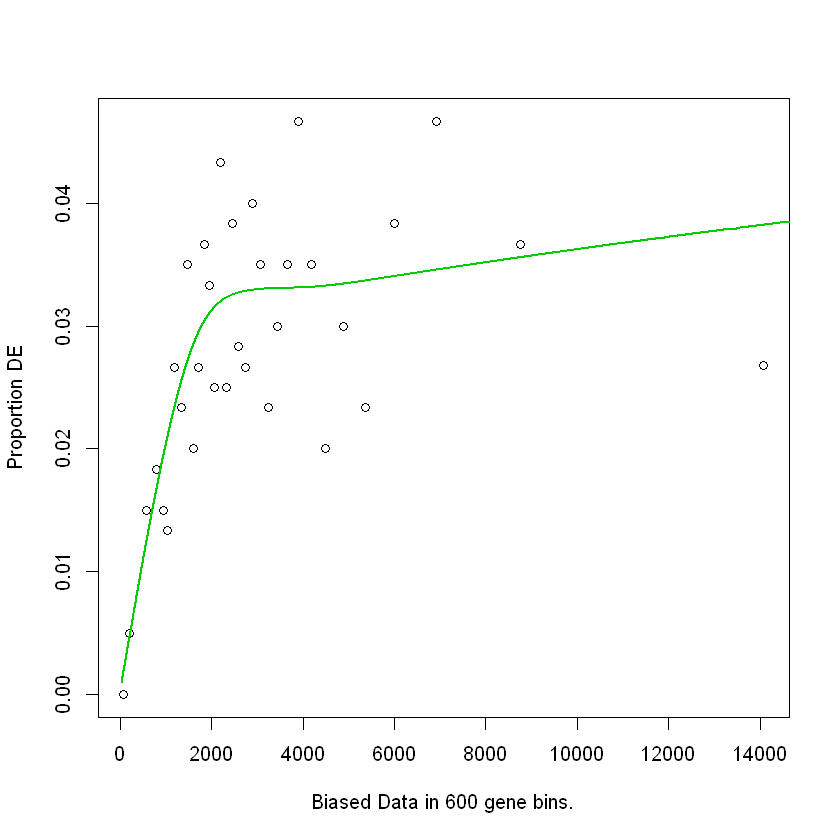

[1] "Well done- the analysis is now complete. Head over to C:/Users/ajn16/Dropbox (Partners HealthCare)/Data/aitl_sam to view your results"


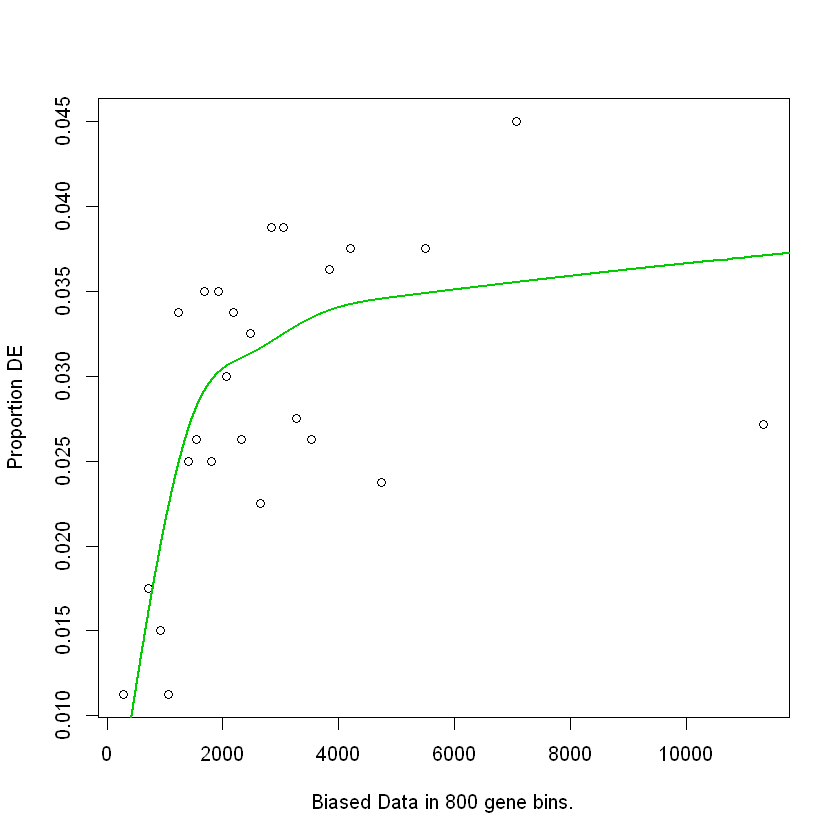

In [11]:
my_plots <- list()
suppressWarnings(goi_deg_pca_gsea_go (exp,meta,contrast=list(A = c("TFH"), B= c("Tonsil_Naive"))))

### Analysing DW23+DFTL47880 v. SMZ1+HH

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Creating a folder to store your results"
[1] "Calculating the differentially expressed genes"
[1] "Generating a heatmap of the diferentially expressed genes"
[1] "Performing Principal Component Analysis"
[1] "Performing GO enrichment analysis"


Loading hg19 length data...
Fetching GO annotations...
For 6542 genes, we could not find any categories. These genes will be excluded.
To force their use, please run with use_genes_without_cat=TRUE (see documentation).
This was the default behavior for version 1.15.1 and earlier.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


[1] "Performing KEGG pathway analysis"


Loading hg19 length data...
Using manually entered categories.
For 17874 genes, we could not find any categories. These genes will be excluded.
To force their use, please run with use_genes_without_cat=TRUE (see documentation).
This was the default behavior for version 1.15.1 and earlier.
Calculating the p-values...


[1] "Preparing for GSEA analysis"
[1] "Performing GSEA with hallmark gene sets"
[1] "Performing GSEA with CGP: chemical and genetic perturbations gene sets"
[1] "Performing GSEA with GO gene sets"
[1] "Performing GSEA with oncogenic signatures"
[1] "Performing GSEA with immunologic signatures"


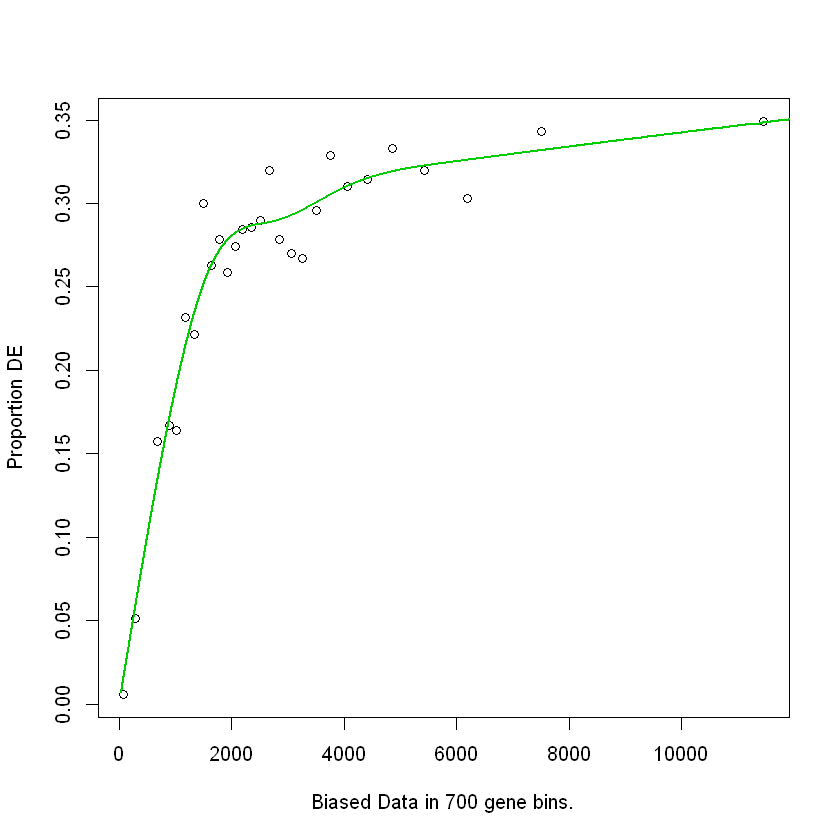

[1] "Well done- the analysis is now complete. Head over to C:/Users/ajn16/Dropbox (Partners HealthCare)/Data/aitl_sam to view your results"


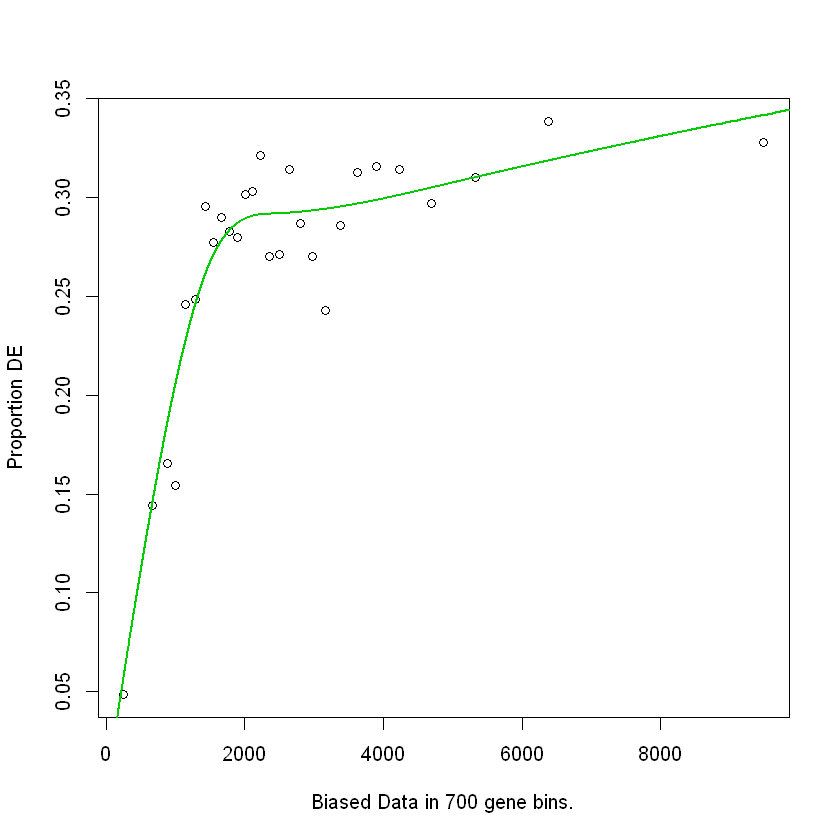

In [15]:
my_plots <- list()
suppressWarnings(goi_deg_pca_gsea_go (exp,meta,contrast=list(A = c("DW23","DFTL_47880"), B= c("SMZ1", "HH"))))

### Analysing DW23+DFTL47880+SMZ1+HH v. TFH+Naive

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 250 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


[1] "Creating a folder to store your results"
[1] "Calculating the differentially expressed genes"
[1] "Generating a heatmap of the diferentially expressed genes"
[1] "Performing Principal Component Analysis"
[1] "Performing GO enrichment analysis"


Loading hg19 length data...
Fetching GO annotations...
For 6542 genes, we could not find any categories. These genes will be excluded.
To force their use, please run with use_genes_without_cat=TRUE (see documentation).
This was the default behavior for version 1.15.1 and earlier.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


[1] "Performing KEGG pathway analysis"


Loading hg19 length data...
Using manually entered categories.
For 17874 genes, we could not find any categories. These genes will be excluded.
To force their use, please run with use_genes_without_cat=TRUE (see documentation).
This was the default behavior for version 1.15.1 and earlier.
Calculating the p-values...


[1] "Preparing for GSEA analysis"
[1] "Performing GSEA with hallmark gene sets"
[1] "Performing GSEA with CGP: chemical and genetic perturbations gene sets"
[1] "Performing GSEA with GO gene sets"
[1] "Performing GSEA with oncogenic signatures"
[1] "Performing GSEA with immunologic signatures"


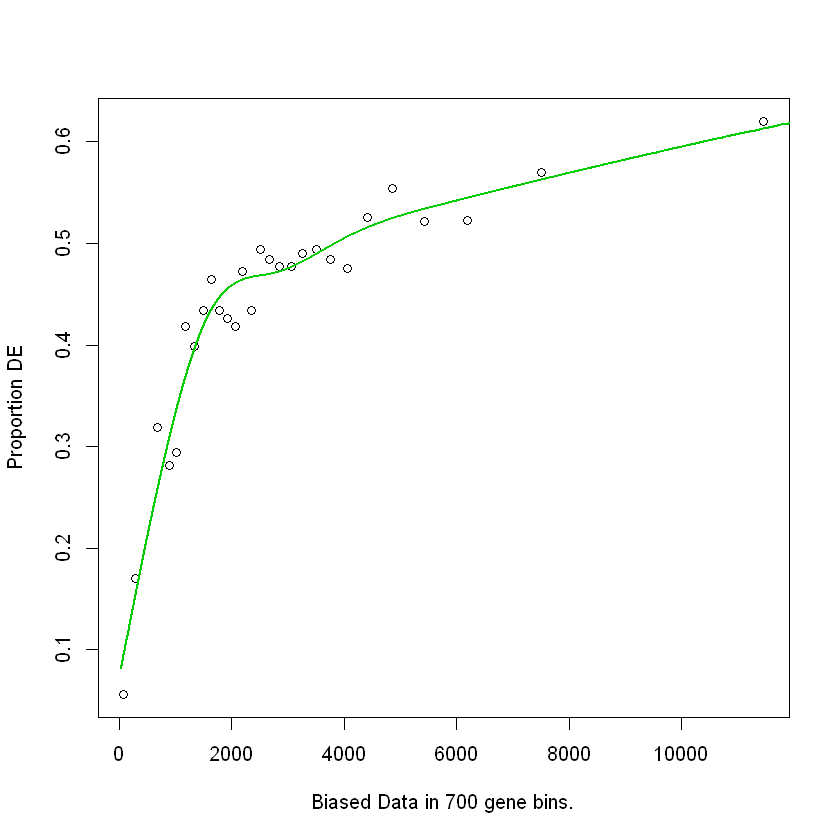

[1] "Well done- the analysis is now complete. Head over to C:/Users/ajn16/Dropbox (Partners HealthCare)/Data/aitl_sam to view your results"


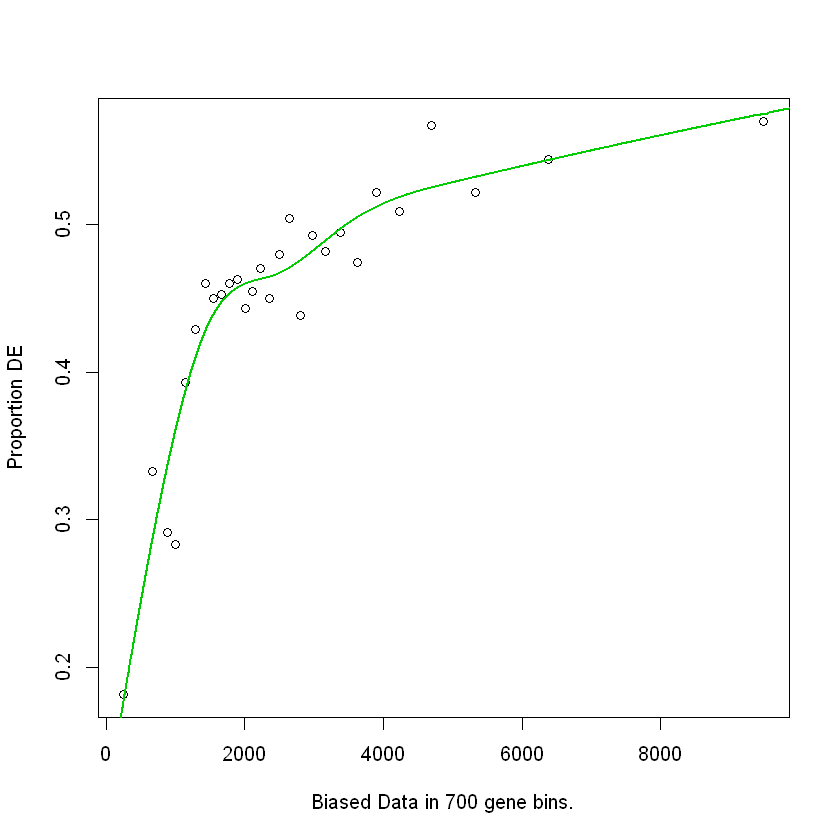

In [16]:
my_plots <- list()
suppressWarnings(goi_deg_pca_gsea_go (exp,meta,contrast=list(A = c("DW23","DFTL_47880","SMZ1","HH"), B= c("TFH", "Tonsil_Naive"))))

### Analysing DW23+DFTL47880 v. TFH

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Creating a folder to store your results"
[1] "Calculating the differentially expressed genes"
[1] "Generating a heatmap of the diferentially expressed genes"
[1] "Performing Principal Component Analysis"
[1] "Performing GO enrichment analysis"


Loading hg19 length data...
Fetching GO annotations...
For 6542 genes, we could not find any categories. These genes will be excluded.
To force their use, please run with use_genes_without_cat=TRUE (see documentation).
This was the default behavior for version 1.15.1 and earlier.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


[1] "Performing KEGG pathway analysis"


Loading hg19 length data...
Using manually entered categories.
For 17874 genes, we could not find any categories. These genes will be excluded.
To force their use, please run with use_genes_without_cat=TRUE (see documentation).
This was the default behavior for version 1.15.1 and earlier.
Calculating the p-values...


[1] "Preparing for GSEA analysis"
[1] "Performing GSEA with hallmark gene sets"
[1] "Performing GSEA with CGP: chemical and genetic perturbations gene sets"
[1] "Performing GSEA with GO gene sets"
[1] "Performing GSEA with oncogenic signatures"
[1] "Performing GSEA with immunologic signatures"


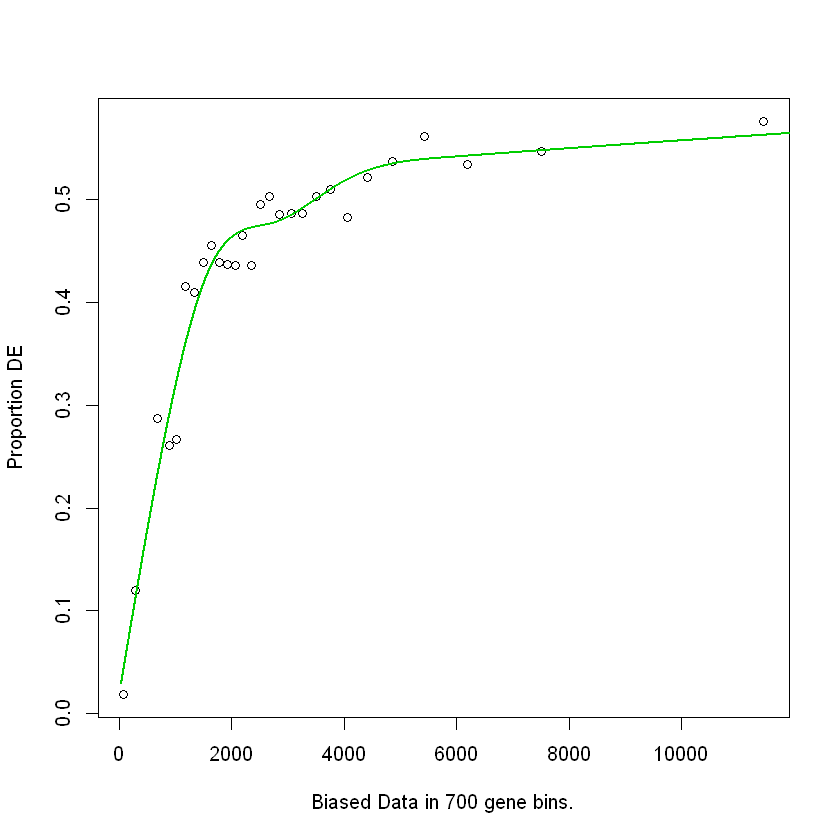

[1] "Well done- the analysis is now complete. Head over to C:/Users/ajn16/Dropbox (Partners HealthCare)/Data/aitl_sam to view your results"


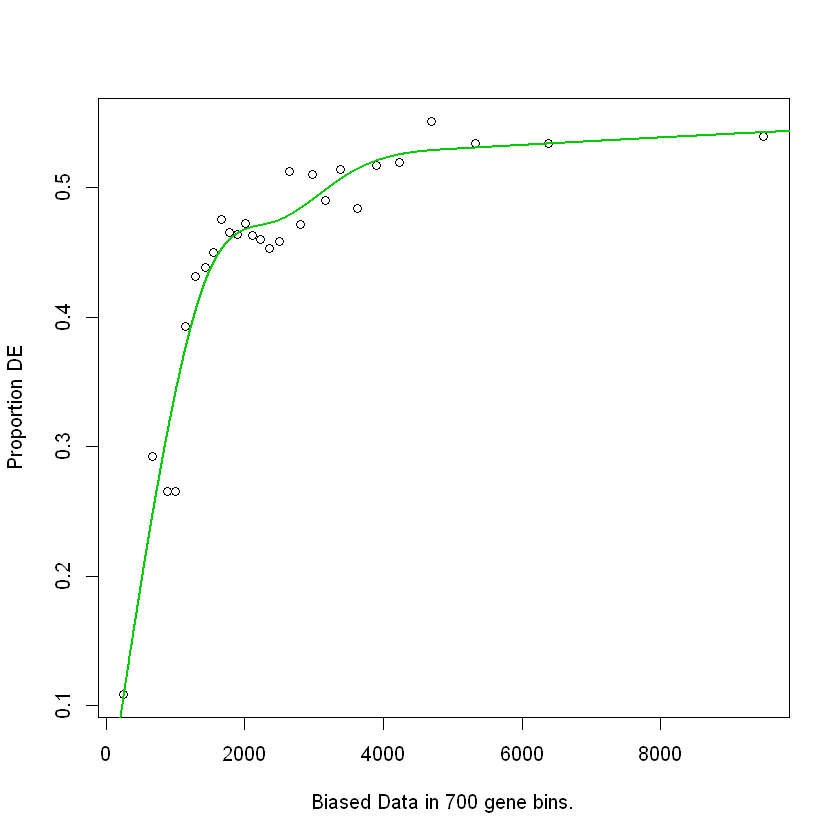

In [9]:
my_plots <- list()
suppressWarnings(goi_deg_pca_gsea_go (exp,meta,contrast=list(A = c("DW23","DFTL_47880"), B= c("TFH"))))

### DW23 + DFTL47880 v. Naive # Pending

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Creating a folder to store your results"
[1] "Calculating the differentially expressed genes"
[1] "Generating a heatmap of the diferentially expressed genes"
[1] "Performing Principal Component Analysis"
[1] "Performing GO enrichment analysis"


Loading hg19 length data...
Fetching GO annotations...
For 6542 genes, we could not find any categories. These genes will be excluded.
To force their use, please run with use_genes_without_cat=TRUE (see documentation).
This was the default behavior for version 1.15.1 and earlier.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


[1] "Performing KEGG pathway analysis"


Loading hg19 length data...
Using manually entered categories.
For 17874 genes, we could not find any categories. These genes will be excluded.
To force their use, please run with use_genes_without_cat=TRUE (see documentation).
This was the default behavior for version 1.15.1 and earlier.
Calculating the p-values...


[1] "Preparing for GSEA analysis"
[1] "Performing GSEA with hallmark gene sets"
[1] "Performing GSEA with CGP: chemical and genetic perturbations gene sets"
[1] "Performing GSEA with GO gene sets"
[1] "Performing GSEA with oncogenic signatures"
[1] "Performing GSEA with immunologic signatures"


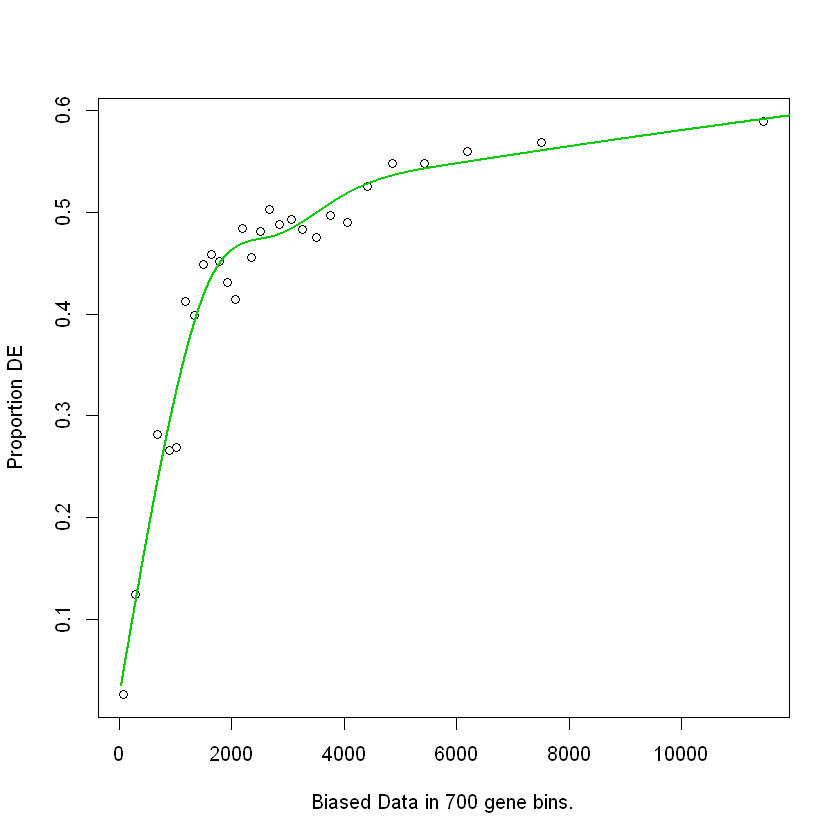

[1] "Well done- the analysis is now complete. Head over to C:/Users/ajn16/Dropbox (Partners HealthCare)/Data/aitl_sam to view your results"


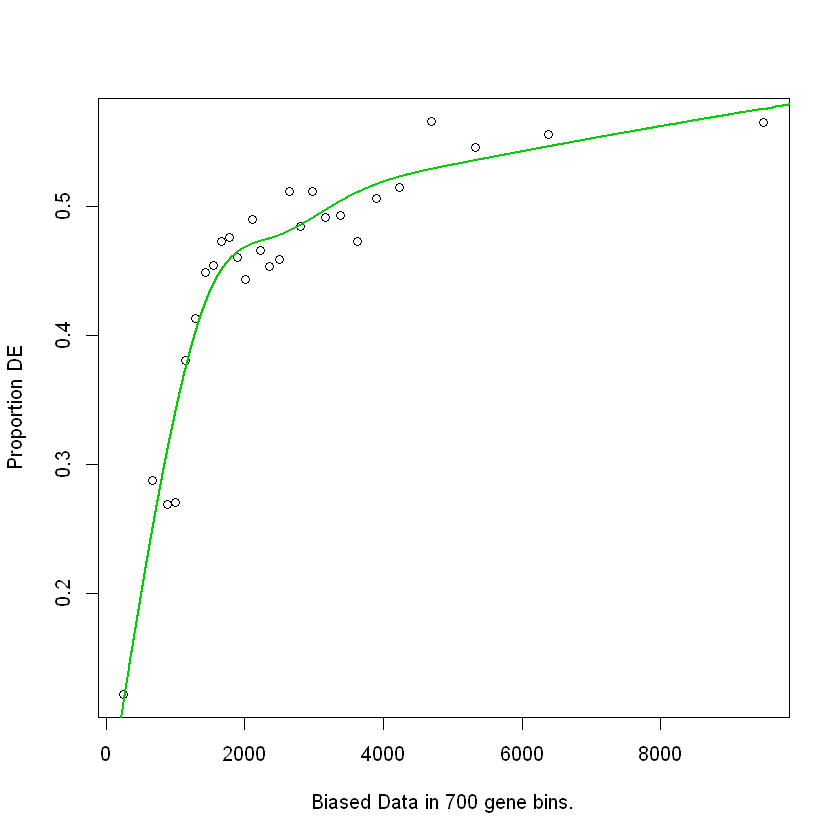

In [10]:
my_plots <- list()
suppressWarnings(goi_deg_pca_gsea_go (exp,meta,contrast=list(A = c("DW23","DFTL_47880"), B= c("Tonsil_Naive"))))

### DW23 v. DFTL47880

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Creating a folder to store your results"
[1] "Calculating the differentially expressed genes"
[1] "Generating a heatmap of the diferentially expressed genes"
[1] "Performing Principal Component Analysis"
[1] "Performing GO enrichment analysis"


Loading hg19 length data...
Fetching GO annotations...
For 6542 genes, we could not find any categories. These genes will be excluded.
To force their use, please run with use_genes_without_cat=TRUE (see documentation).
This was the default behavior for version 1.15.1 and earlier.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


[1] "Performing KEGG pathway analysis"


Loading hg19 length data...
Using manually entered categories.
For 17874 genes, we could not find any categories. These genes will be excluded.
To force their use, please run with use_genes_without_cat=TRUE (see documentation).
This was the default behavior for version 1.15.1 and earlier.
Calculating the p-values...


[1] "Preparing for GSEA analysis"
[1] "Performing GSEA with hallmark gene sets"


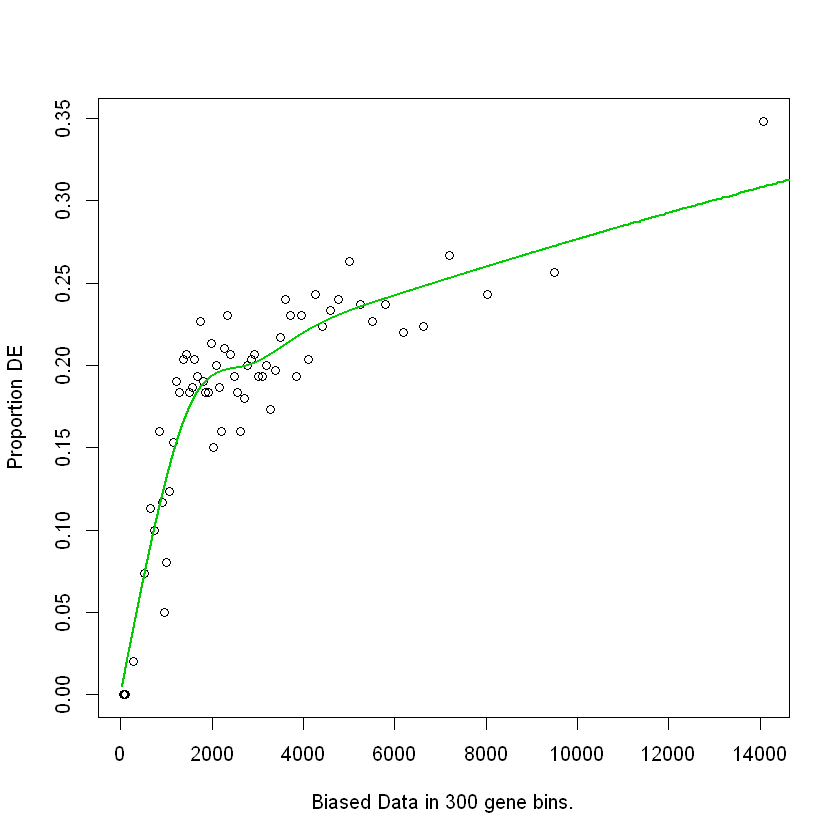

[1] "Performing GSEA with CGP: chemical and genetic perturbations gene sets"
[1] "Hey watch out- There was no significant genesets to plot"
[1] "Performing GSEA with GO gene sets"
[1] "Hey watch out- There was no significant genesets to plot"
[1] "Performing GSEA with oncogenic signatures"
[1] "Hey watch out- There was no significant genesets to plot"
[1] "Performing GSEA with immunologic signatures"
[1] "Hey watch out- There was no significant genesets to plot"
[1] "Well done- the analysis is now complete. Head over to C:/Users/ajn16/Dropbox (Partners HealthCare)/Data/aitl_sam to view your results"


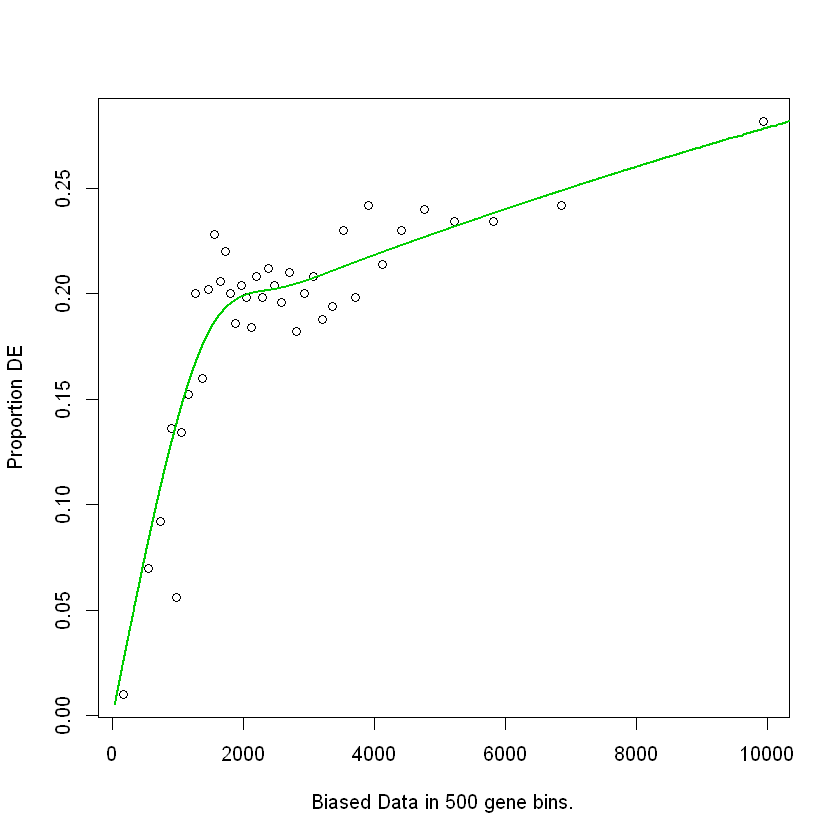

In [11]:
my_plots <- list()
suppressWarnings(goi_deg_pca_gsea_go (exp,meta,contrast=list(A = c("DW23"), B= c("DFTL_47880"))))

### DW23 + DFTL47880 v. TFH+Naive

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Creating a folder to store your results"
[1] "Calculating the differentially expressed genes"
[1] "Generating a heatmap of the diferentially expressed genes"
[1] "Performing Principal Component Analysis"
[1] "Performing GO enrichment analysis"


Loading hg19 length data...
Fetching GO annotations...
For 6542 genes, we could not find any categories. These genes will be excluded.
To force their use, please run with use_genes_without_cat=TRUE (see documentation).
This was the default behavior for version 1.15.1 and earlier.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


[1] "Performing KEGG pathway analysis"


Loading hg19 length data...
Using manually entered categories.
For 17874 genes, we could not find any categories. These genes will be excluded.
To force their use, please run with use_genes_without_cat=TRUE (see documentation).
This was the default behavior for version 1.15.1 and earlier.
Calculating the p-values...


[1] "Preparing for GSEA analysis"
[1] "Performing GSEA with hallmark gene sets"
[1] "Performing GSEA with CGP: chemical and genetic perturbations gene sets"
[1] "Performing GSEA with GO gene sets"
[1] "Performing GSEA with oncogenic signatures"
[1] "Performing GSEA with immunologic signatures"


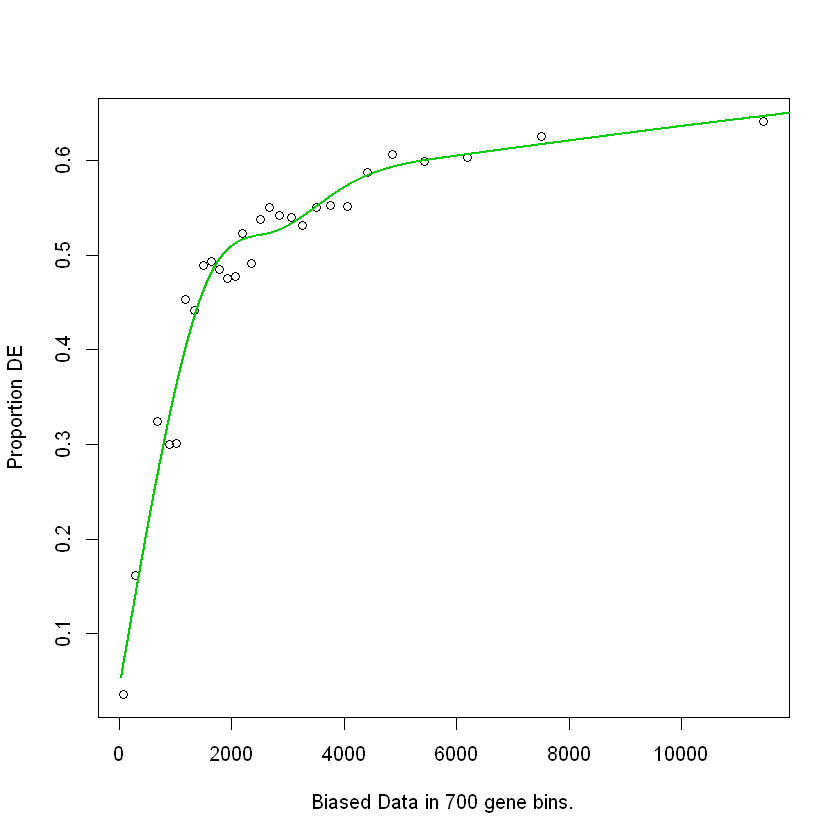

[1] "Well done- the analysis is now complete. Head over to C:/Users/ajn16/Dropbox (Partners HealthCare)/Data/aitl_sam to view your results"


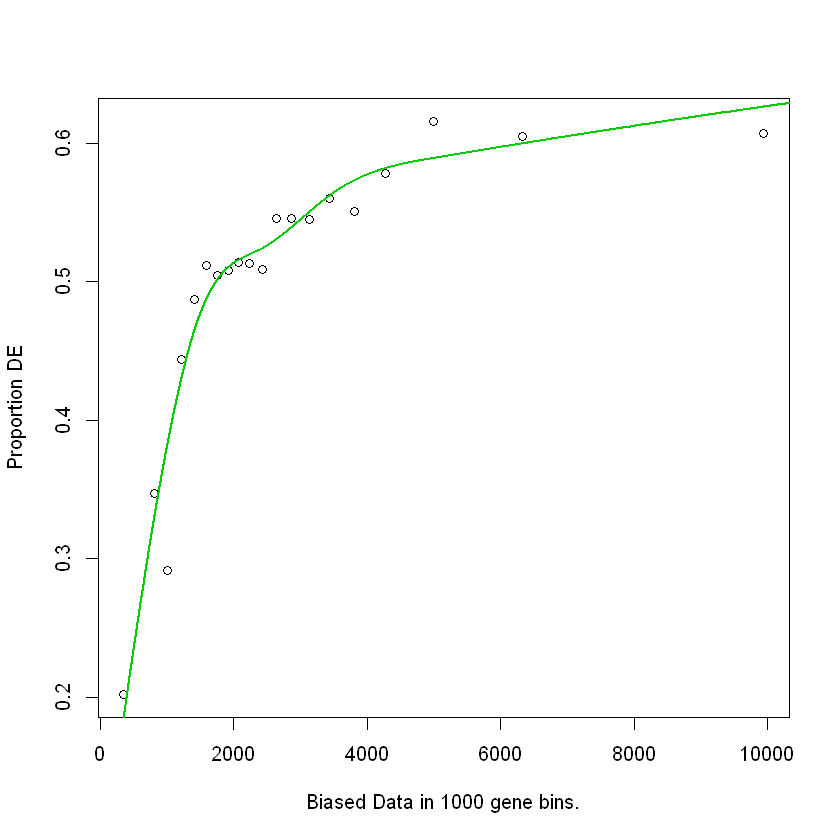

In [12]:
my_plots <- list()
suppressWarnings(goi_deg_pca_gsea_go (exp,meta,contrast=list(A = c("DW23","DFTL_47880"), B= c("TFH", "Tonsil_Naive"))))

### DFTL47880 v. TFH

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Creating a folder to store your results"
[1] "Calculating the differentially expressed genes"
[1] "Generating a heatmap of the diferentially expressed genes"
[1] "Performing Principal Component Analysis"
[1] "Performing GO enrichment analysis"


Loading hg19 length data...
Fetching GO annotations...
For 6542 genes, we could not find any categories. These genes will be excluded.
To force their use, please run with use_genes_without_cat=TRUE (see documentation).
This was the default behavior for version 1.15.1 and earlier.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


[1] "Performing KEGG pathway analysis"


Loading hg19 length data...
Using manually entered categories.
For 17874 genes, we could not find any categories. These genes will be excluded.
To force their use, please run with use_genes_without_cat=TRUE (see documentation).
This was the default behavior for version 1.15.1 and earlier.
Calculating the p-values...


[1] "Preparing for GSEA analysis"
[1] "Performing GSEA with hallmark gene sets"
[1] "Performing GSEA with CGP: chemical and genetic perturbations gene sets"
[1] "Performing GSEA with GO gene sets"
[1] "Performing GSEA with oncogenic signatures"
[1] "Performing GSEA with immunologic signatures"


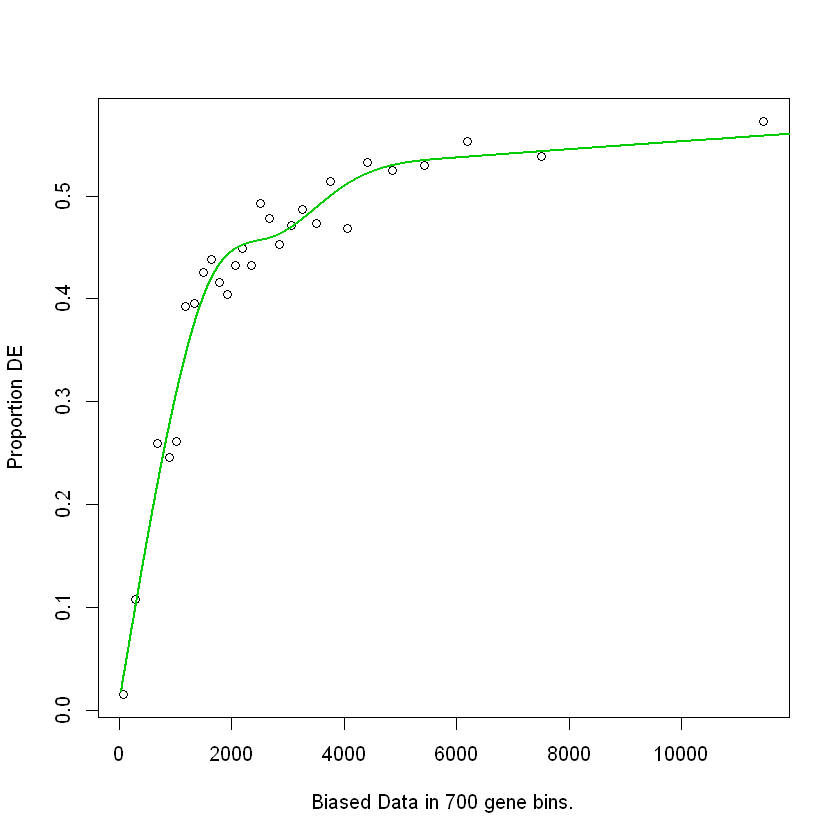

[1] "Well done- the analysis is now complete. Head over to C:/Users/ajn16/Dropbox (Partners HealthCare)/Data/aitl_sam to view your results"


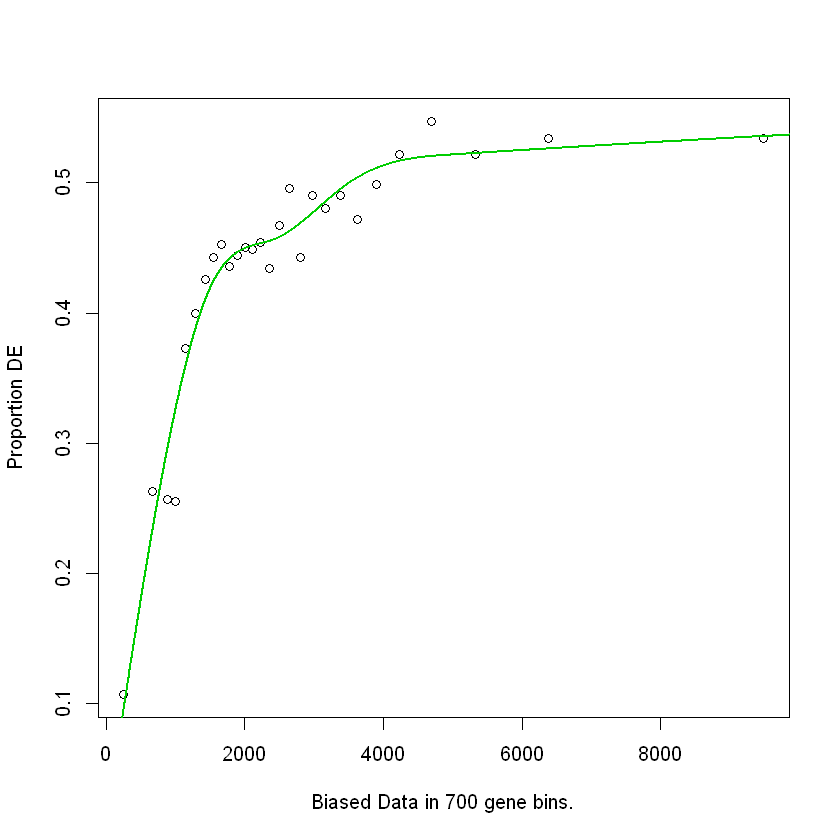

In [13]:
my_plots <- list()
suppressWarnings(goi_deg_pca_gsea_go (exp,meta,contrast=list(A = c("DFTL_47880"), B= c("TFH"))))

### DW23 v. TFH

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Creating a folder to store your results"
[1] "Calculating the differentially expressed genes"
[1] "Generating a heatmap of the diferentially expressed genes"
[1] "Performing Principal Component Analysis"
[1] "Performing GO enrichment analysis"


Loading hg19 length data...
Fetching GO annotations...
For 6542 genes, we could not find any categories. These genes will be excluded.
To force their use, please run with use_genes_without_cat=TRUE (see documentation).
This was the default behavior for version 1.15.1 and earlier.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


[1] "Performing KEGG pathway analysis"


Loading hg19 length data...
Using manually entered categories.
For 17874 genes, we could not find any categories. These genes will be excluded.
To force their use, please run with use_genes_without_cat=TRUE (see documentation).
This was the default behavior for version 1.15.1 and earlier.
Calculating the p-values...


[1] "Preparing for GSEA analysis"
[1] "Performing GSEA with hallmark gene sets"
[1] "Performing GSEA with CGP: chemical and genetic perturbations gene sets"
[1] "Performing GSEA with GO gene sets"
[1] "Performing GSEA with oncogenic signatures"
[1] "Performing GSEA with immunologic signatures"


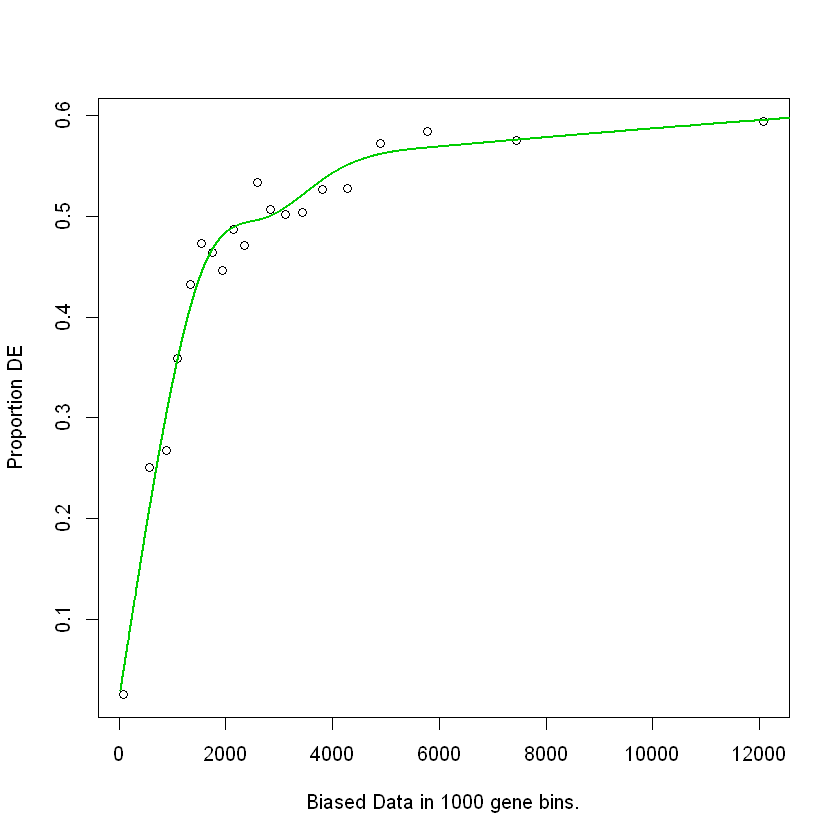

[1] "Well done- the analysis is now complete. Head over to C:/Users/ajn16/Dropbox (Partners HealthCare)/Data/aitl_sam to view your results"


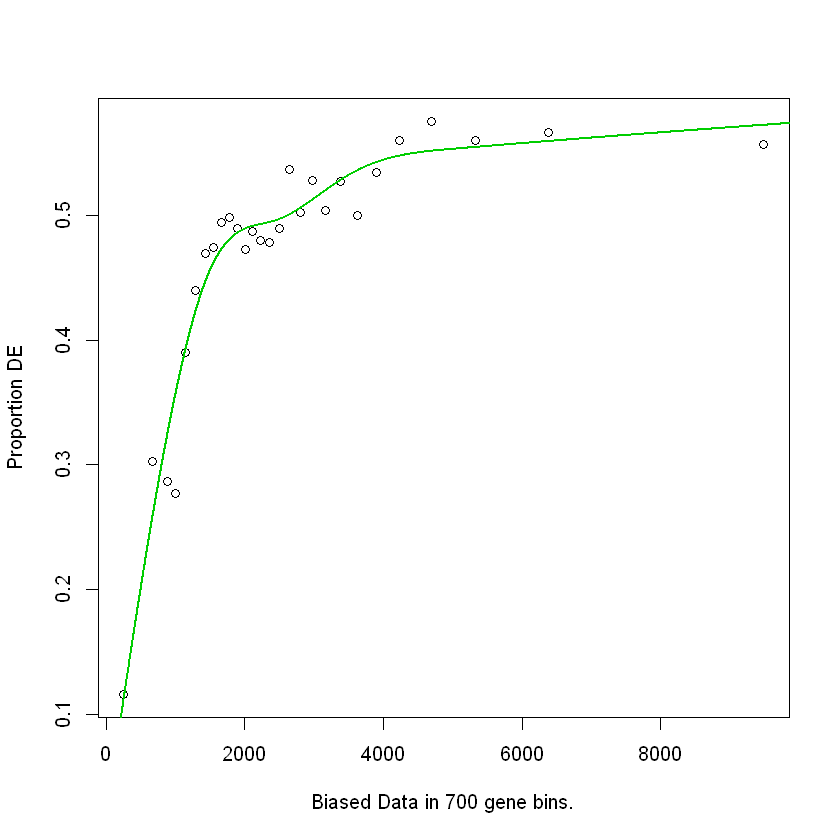

In [14]:
my_plots <- list()
suppressWarnings(goi_deg_pca_gsea_go (exp,meta,contrast=list(A = c("DW23"), B= c("TFH"))))

## PCA analysis

In [11]:
pca_subset <- function(dds,goi){
  require(ggplot2)
  require(DESeq2)
  print("Creating a folder to store your results")
  dir.create("DGE+PCA+G0+KEGG+GSEA")
  dir.create("DGE+PCA+G0+KEGG+GSEA/PCA")
  location <- "DGE+PCA+G0+KEGG+GSEA/PCA/"
  # Subset groups of interest from the main dds
  dds_subset <- dds[ , dds$group %in% goi ]
  dds_subset$group <- factor(dds_subset$group)
  # Perform the PCA analysis
  print("Performing Principal Component Analysis")
  rld_dds_subset<- rlog(dds_subset, blind=FALSE)
  pcaData <- plotPCA(rld_dds_subset, intgroup= "group", returnData=TRUE)
  percentVar <- round(100 * attr(pcaData, "percentVar"))
  pca.plot <-   ggplot(pcaData, aes(PC1, PC2, color=group)) + geom_label(aes(label = name)) +
    theme_bw()+ theme(legend.position = "none")
  pdf(paste(location,"PCA- ",goi,".pdf"),width=6,height=6,paper='special')
  plot(pca.plot)
  dev.off()
}

In [12]:
# PCA-1 (All samples)
goi <- levels(dds$group)
pca_subset (dds,goi)

[1] "Creating a folder to store your results"


Warning message in dir.create("DGE+PCA+G0+KEGG+GSEA"):
“'DGE+PCA+G0+KEGG+GSEA' already exists”Warning message in dir.create("DGE+PCA+G0+KEGG+GSEA/PCA"):
“'DGE+PCA+G0+KEGG+GSEA/PCA' already exists”

[1] "Performing Principal Component Analysis"


pdf 
  2

In [15]:
# PCA-2 DW23, DFTL47880, HH, SMZ1
pca_subset (dds,goi= c("DW23", "DFTL_47880", "HH", "SMZ1"))

[1] "Creating a folder to store your results"


Warning message in dir.create("DGE+PCA+G0+KEGG+GSEA"):
“'DGE+PCA+G0+KEGG+GSEA' already exists”Warning message in dir.create("DGE+PCA+G0+KEGG+GSEA/PCA"):
“'DGE+PCA+G0+KEGG+GSEA/PCA' already exists”

[1] "Performing Principal Component Analysis"


pdf 
  2

In [16]:
# PCA-3 TFH, Naïve
pca_subset (dds,goi= c("TFH", "Tonsil_Naive"))

[1] "Creating a folder to store your results"


Warning message in dir.create("DGE+PCA+G0+KEGG+GSEA"):
“'DGE+PCA+G0+KEGG+GSEA' already exists”Warning message in dir.create("DGE+PCA+G0+KEGG+GSEA/PCA"):
“'DGE+PCA+G0+KEGG+GSEA/PCA' already exists”

[1] "Performing Principal Component Analysis"


pdf 
  2

In [17]:
# PCA-4 DW23, DFTL47880
pca_subset (dds,goi= c("DW23", "DFTL_47880"))

[1] "Creating a folder to store your results"


Warning message in dir.create("DGE+PCA+G0+KEGG+GSEA"):
“'DGE+PCA+G0+KEGG+GSEA' already exists”Warning message in dir.create("DGE+PCA+G0+KEGG+GSEA/PCA"):
“'DGE+PCA+G0+KEGG+GSEA/PCA' already exists”

[1] "Performing Principal Component Analysis"


pdf 
  2